# SRM | Signal Request Message Counts
Notebook to calculate SRM counts

Version | Date | Author | Notes |
:------:|:----:|:------:|:--------
1.0     | 21 July 2022 | Ken Dizon - CDOT OIM  | Initial version 
1.1     | 10 Nov 2022  | Ken Dizon - CDOT OIM  | Query Input Parameters
2.0     | 07 Feb 2023  | Ken Dizon - CDOT OIM  | Data Visualization

**[OBU] sends ➡ SRM**
- Locate valid Signal Request Messages in a RSU.
- SRM (Signal Request Message) as not all intersections will receive a request.
- Broadcast by a vehicle (OnBoard Unit) to infrastructure (Roadside Unit)

_______________
**Content**
- Libraries & Packages
- SQL Setup & Parameters
- Query
1. SRM: Signal Request Message
    * 1.1 Counts
    * 1.2 Visualization

In [3]:
# Importing Libraries
from google.cloud import bigquery

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import (datetime, timedelta)

SQL Big Query Setup & Parameters

In [9]:
# BigQuery Connection
client = bigquery.Client(location="US", project="cdot-adap-wb-stage")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: cdot-adap-wb-stage


In [8]:
# From a start date and input number of days after
start_date = input('Enter a start date in (YYYY-MM-DD): ')
start_date = datetime.strptime(start_date, "%Y-%m-%d").date()

num_days = int(input("Enter number of days: "))
end_date = start_date + timedelta(days=num_days)
print('End date:', end_date)

Enter a start date in (YYYY-MM-DD):  2023-01-01
Enter number of days:  30


End date: 2023-01-31


Query

In [10]:
%%time

query = """
SELECT
    srm.metadata.originIp AS rsuIP,
    DATE(
        EXTRACT(YEAR FROM TIMESTAMP(srm.metadata.odeReceivedAt) AT TIME ZONE "America/Denver"),
        EXTRACT(MONTH FROM TIMESTAMP(srm.metadata.odeReceivedAt) AT TIME ZONE "America/Denver"),
        EXTRACT(DAY FROM TIMESTAMP(srm.metadata.odeReceivedAt) AT TIME ZONE "America/Denver")
    ) AS localDate,
    count(1) AS SRM_count
FROM cdot-adap-prod.raw_from_rtdh_standard.cv_srm_standard
WHERE srm.metadata.originIp LIKE @Region1
    AND DATETIME(TIMESTAMP(srm.metadata.odeReceivedAt), \"America/Denver\") BETWEEN @start_date AND @end_date
GROUP BY localDate, rsuIP
ORDER BY localDate, rsuIP
"""

query_params = [ 
    bigquery.ScalarQueryParameter("Region1", "STRING", '%10.11.81%'), # displays SRM counts by using all RSUs from 10.11.81.## located on Wadsworth Blvd
    bigquery.ScalarQueryParameter("start_date", "DATE", start_date), 
    bigquery.ScalarQueryParameter("end_date", "DATE", end_date), 
]

job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params

CPU times: user 41 µs, sys: 9 µs, total: 50 µs
Wall time: 54.4 µs


## Signal Request Message

In [11]:
# execute the query
SRM = client.query(query, job_config=job_config).to_dataframe()
SRM.head()

,rsuIP,localDate,SRM_count
0,10.11.81.18,2023-01-01,95
1,10.11.81.19,2023-01-01,74
2,10.11.81.14,2023-01-02,111
3,10.11.81.18,2023-01-02,480
4,10.11.81.19,2023-01-02,437


In [12]:
# pivot
SRMCountTable = pd.pivot(SRM,index='localDate', columns='rsuIP', values='SRM_count').fillna(0)

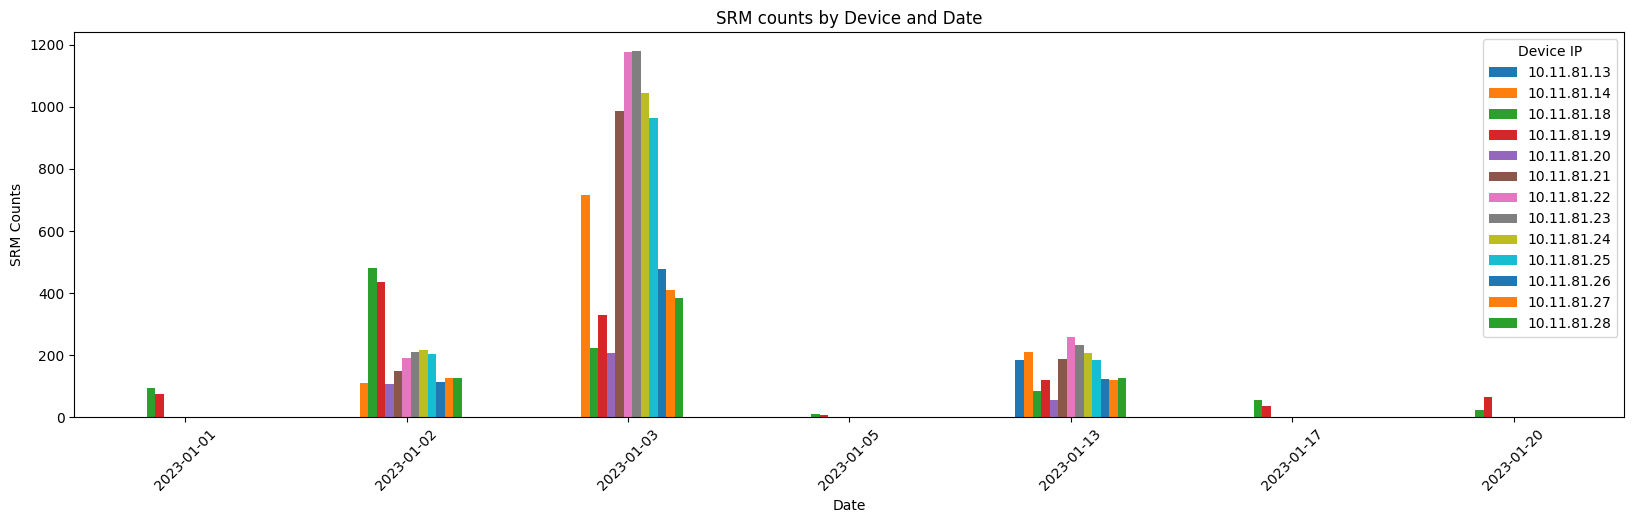

In [13]:
# Plot a bar chart using the PivotTable
ax = SRMCountTable.plot(kind="bar")

fig = ax.get_figure()
fig.set_size_inches(20, 5)

# Add some labels and a legend
ax.set_title('SRM counts by Device and Date')
ax.legend(title='Device IP')
ax.set_xlabel('Date')
ax.set_ylabel('SRM Counts')
plt.xticks(rotation=45)
plt.show()